## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>


### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### 1. Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [62]:
import pandas as pd
import numpy as np
import pickle
import random
import shap

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from catboost import Pool, cv
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

In [63]:
import warnings
warnings.simplefilter('ignore')

In [64]:
# input
TRAIN_DATASET_PATH = './course_project_train.csv'

# output
TEST_DATASET_PATH = './course_project_test.csv'

In [65]:
#проверим тест
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [66]:
test_df.shape

(2500, 16)

In [67]:
#дальше работаем с трейновым датасетом
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [69]:
df.shape

(7500, 17)

In [70]:
#смотрим первую строку
df.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [72]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [73]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### Выделение целевой переменной и групп признаков

In [74]:
TARGET = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Анализ целевой переменной

#### Обзор распределения

In [75]:
# 0-го класса более, чем в 2 раза больше, чем 1-го
df[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

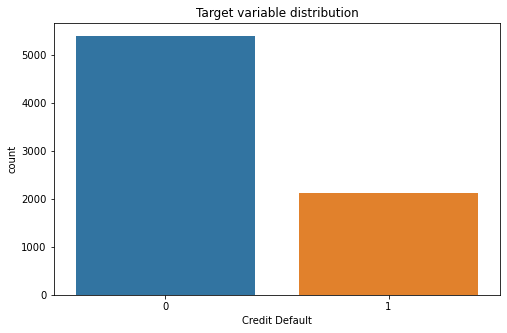

In [76]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET, data=df)

plt.title('Target variable distribution')
plt.show()

In [77]:
#Количество пропусков
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

###### Выводы: 
1. 0-го класса более, чем в 2 раза больше, чем 1-го
2. Пропуски есть в 4х признаках:

Annual Income                   1557

Years in current job             371

Months since last delinquent    4081

Credit Score                    1557

Так как в Months since last delinquent пропусков больше половины (всего строк 7500), то этот параметр придется не использовать при обучении модели.


### 2. Обработка выбросов<a class="anchor" id="course_project_review"></a>

In [78]:
"""Функция для расчета и изображения на графике медианы и среднего значения заданного показателя"""
def f_plot_distribution(feature, bins_val=10):
    feature_mean = round(df[feature].mean(), 2)
    feature_median = df[feature].median()

    plt.figure(figsize = (12, 6))

    sns.distplot(df[feature], bins=bins_val)

    y = np.linspace(0, 0.000005, 10)
    plt.plot([feature_mean] * 10, y, label='mean',  linewidth=4)
    plt.plot([feature_median] * 10, y, label='median',  linewidth=4)

    plt.title('Distribution of ' + feature)
    plt.legend(loc='upper left')
    plt.show()
    print(f"\tMean= {feature_mean}    Median= {feature_median}  ")
    return

In [79]:
#Home Ownership
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [80]:
# plt.figure(figsize=(8, 5))

# sns.countplot(x='Home Ownership', data=df)

# plt.title('Target variable distribution')
# plt.show()

In [81]:
# sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
# plt.show()

In [82]:
#преобразуем их в dummies
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,Short Term,99999999.0,308389.0,13651.0,742.0,0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,...,Short Term,129360.0,73492.0,1900.0,697.0,0,0,0,0,1
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,...,Long Term,444048.0,456399.0,12783.0,7410.0,1,0,1,0,0
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,...,Short Term,99999999.0,477812.0,12479.0,748.0,0,0,0,0,1
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,...,Short Term,615274.0,476064.0,37118.0,NaN,0,0,1,0,0


In [83]:
#Annual Income
df['Annual Income'].value_counts()

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64

In [84]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

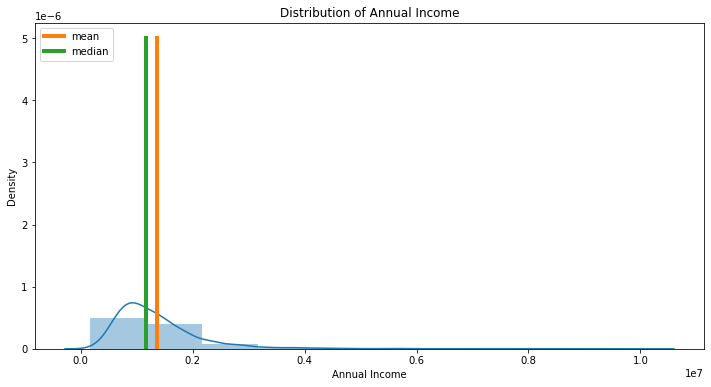

	Mean= 1366391.72    Median= 1168386.0  


In [85]:
 f_plot_distribution('Annual Income')
# среднее правее медианы - значит выбросы справа

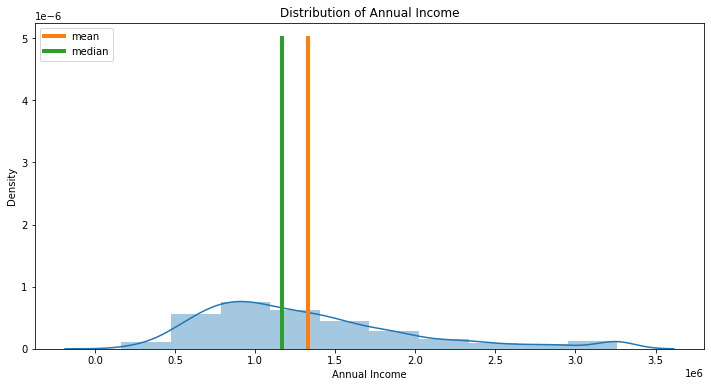

	Mean= 1326514.21    Median= 1168386.0  


In [86]:
# выбросы заменим на 97-ю квантиль
wired_income = np.percentile(df.loc[df['Annual Income'].notna(),'Annual Income'], 97)
df['Annual Income Outlier'] = 0
df.loc[df['Annual Income'] > wired_income, 'Annual Income Outlier'] = 1
df.loc[df['Annual Income'] > wired_income, 'Annual Income'] = wired_income

f_plot_distribution('Annual Income')

In [87]:
df['Annual Income Outlier'].value_counts()

0    7321
1     179
Name: Annual Income Outlier, dtype: int64

In [88]:
#Years in current job
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [89]:
#371 пропуск
len(df) - df['Years in current job'].count()

371

In [90]:
#заменим потом на моду или на >1
df['Years in current job'].mode()

0    10+ years
dtype: object

In [91]:
# plt.figure(figsize=(8, 5))

# sns.countplot(x='Years in current job', data=df)

# plt.title('Target variable distribution')
# plt.show()

In [92]:
# sns.countplot(x='Years in current job', hue='Credit Default', data=df)
# plt.show()

In [93]:
#Tax Liens
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [94]:
#пропусков нет
len(df) - df['Tax Liens'].count()

0

In [95]:
# plt.figure(figsize=(8, 5))

# sns.countplot(x='Tax Liens', data=df)

# plt.title('Target variable distribution')
# plt.show()

In [96]:
# sns.countplot(x='Tax Liens', hue='Credit Default', data=df)
# plt.show()

In [97]:
#Number of Open Accounts
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
41.0      1
38.0      1
35.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [98]:
#нет пропусков
len(df) - df['Number of Open Accounts'].count()

0

In [99]:
#небольшие выбросы справа
# f_plot_distribution('Number of Open Accounts')

In [100]:
# выбросы заменим на 99-ю квантиль
wired_accounts = np.percentile(df.loc[df['Number of Open Accounts'].notna(),'Number of Open Accounts'], 99)
df['Number of Open Accounts Outlier'] = 0
df.loc[df['Number of Open Accounts'] > wired_accounts, 'Number of Open Accounts Outlier'] = 1
df.loc[df['Number of Open Accounts'] > wired_accounts, 'Number of Open Accounts'] = wired_accounts

#f_plot_distribution('Number of Open Accounts')

In [101]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,47386.0,7914.0,749.0,0,0,0,1,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,394972.0,18373.0,737.0,1,0,0,1,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,308389.0,13651.0,742.0,0,0,1,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,95855.0,11338.0,694.0,0,0,0,1,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,93309.0,7180.0,719.0,0,0,0,0,1,0,0


In [102]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
27.0     76
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
26.0     12
Name: Number of Open Accounts, dtype: int64

In [103]:
#Years of Credit History
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

In [104]:
#нет пропусков
len(df) - df['Years of Credit History'].count()

0

In [105]:
#f_plot_distribution('Years of Credit History')

In [106]:
# выбросы заменим на 97-ю квантиль
wired_history = np.percentile(df.loc[df['Years of Credit History'].notna(),'Years of Credit History'], 97)
df['Years of Credit History Outlier'] = 0
df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History Outlier'] = 1
df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History'] = wired_history

#f_plot_distribution('Years of Credit History')

In [107]:
wired_history = np.percentile(df.loc[df['Years of Credit History'].notna(),'Years of Credit History'], 97)
wired_history

34.4

In [108]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier,Years of Credit History Outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,7914.0,749.0,0,0,0,1,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,18373.0,737.0,1,0,0,1,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,34.4,1182434.0,0.0,NaN,0.0,...,13651.0,742.0,0,0,1,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,11338.0,694.0,0,0,0,1,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,7180.0,719.0,0,0,0,0,1,0,0,0


In [109]:
#Maximum Open Credit
df['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

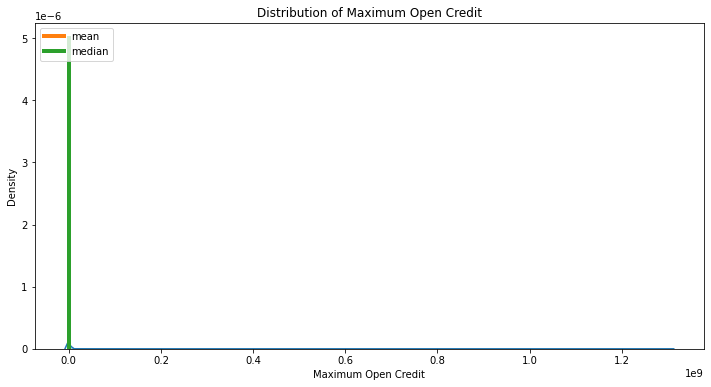

	Mean= 945153.73    Median= 478159.0  


In [110]:
f_plot_distribution('Maximum Open Credit')

In [111]:
#пропусков нет
len(df) - df['Maximum Open Credit'].count()

0

In [112]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [113]:
# выбросы заменим на 97-ю квантиль
# wired_credit = np.percentile(df.loc[df['Years of Credit History'].notna(),'Years of Credit History'], 97)
# df['Years of Credit History Outlier'] = 0
# df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History Outlier'] = 1
# df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History'] = wired_history

#f_plot_distribution('Years of Credit History')

In [114]:
wired_credit = np.percentile(df.loc[df['Maximum Open Credit'].notna(),'Maximum Open Credit'], 97.5)
wired_credit

2236204.2999999984

In [115]:
condition = ((df['Maximum Open Credit'] == 0) | (df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.975)))
df['Maximum Open Credit Outlier'] = 0
# помечаем выбросы
df.loc[condition, 'Maximum Open Credit Outlier'] = 1
#меняем на квантиль
df.loc[condition, 'Maximum Open Credit'] = df['Maximum Open Credit'].quantile(.975)

In [116]:
df['Maximum Open Credit'].value_counts()

2236204.3    253
319110.0       5
334796.0       3
594594.0       3
513524.0       3
            ... 
1151810.0      1
454718.0       1
909722.0       1
263120.0       1
480832.0       1
Name: Maximum Open Credit, Length: 6776, dtype: int64

In [117]:
#Number of Credit Problems
df['Number of Credit Problems'].value_counts()
#суть классификации этого признака непонятна -пока так и оставим. 

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [118]:
#Months since last delinquent не изучаем так, как там пропусков больше половины - надо выбрасывать этот признак

In [119]:
#Bankruptcies
# 14 пропусков
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [120]:
#Purpose
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [121]:
#Term
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [122]:
#Current Loan Amount
df['Current Loan Amount'].value_counts()
#надо убрать неадекватные значения 99999999.0    870

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

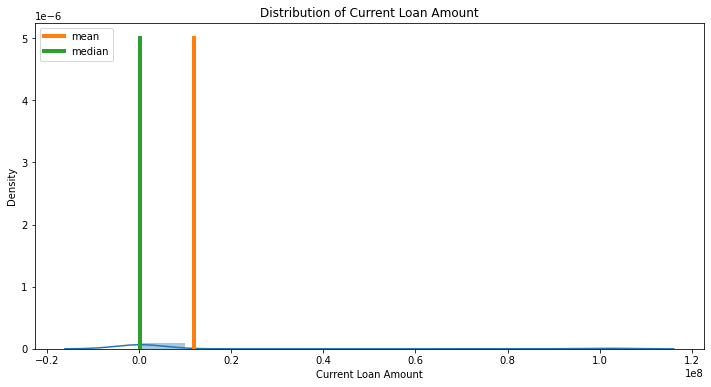

	Mean= 11873177.45    Median= 309573.0  


In [123]:
f_plot_distribution('Current Loan Amount')

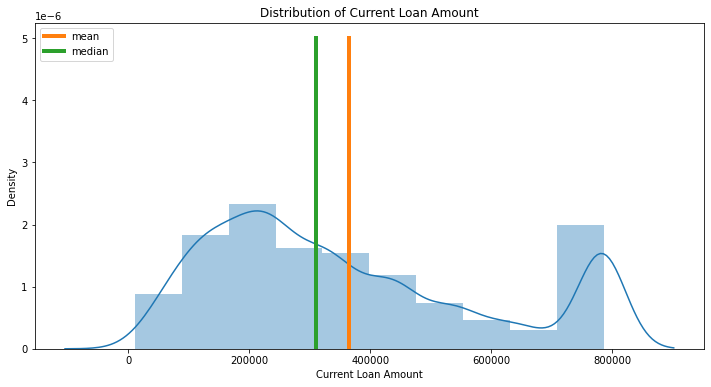

	Mean= 364332.23    Median= 309573.0  


In [124]:
# выбросы заменим на 88-ю квантиль
wired_amount = np.percentile(df.loc[df['Current Loan Amount'].notna(),'Current Loan Amount'], 88)
df['Current Loan Amount Outlier'] = 0
df.loc[df['Current Loan Amount'] > wired_amount, 'Current Loan Amount Outlier'] = 1
df.loc[df['Current Loan Amount'] > wired_amount, 'Current Loan Amount'] = wired_amount

f_plot_distribution('Current Loan Amount')

In [125]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier,Years of Credit History Outlier,Maximum Open Credit Outlier,Current Loan Amount Outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,1,0,0,1,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,34.4,1182434.0,0.0,NaN,0.0,...,0,0,1,0,0,0,0,1,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,0


In [126]:
#Current Credit Balance 
df['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
106818.0     4
83638.0      4
136401.0     4
            ..
445360.0     1
243371.0     1
25688.0      1
62054.0      1
288192.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

In [127]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

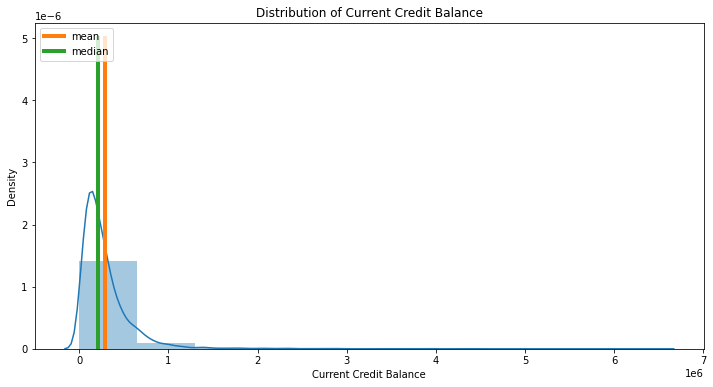

	Mean= 289833.24    Median= 209323.0  


In [128]:
f_plot_distribution('Current Credit Balance')

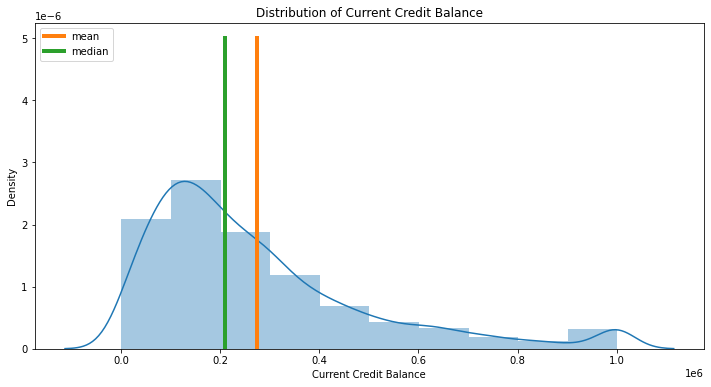

	Mean= 273713.06    Median= 209323.0  


In [129]:
#выбросы заменяем на квантиль 97.5
wired_balance = np.percentile(df.loc[df['Current Credit Balance'].notna(),'Current Credit Balance'], 97.5)
df['Current Credit Balance Outlier'] = 0
df.loc[df['Current Credit Balance'] > wired_balance, 'Current Credit Balance Outlier'] = 1
df.loc[df['Current Credit Balance'] > wired_balance, 'Current Credit Balance'] = wired_balance

f_plot_distribution('Current Credit Balance')

In [130]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier,Years of Credit History Outlier,Maximum Open Credit Outlier,Current Loan Amount Outlier,Current Credit Balance Outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,1,0,0,0,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,0,0,1,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,34.4,1182434.0,0.0,NaN,0.0,...,0,1,0,0,0,0,1,0,1,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,0,0,0,1,0,0,0,0,0,0


In [131]:
#Monthly Debt 
df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
12986.0    3
13356.0    3
          ..
33217.0    1
8203.0     1
15150.0    1
1992.0     1
9061.0     1
Name: Monthly Debt, Length: 6716, dtype: int64

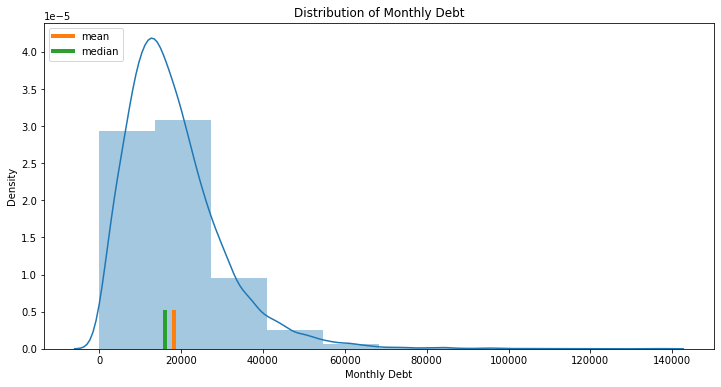

	Mean= 18314.45    Median= 16076.5  


In [132]:
f_plot_distribution('Monthly Debt')

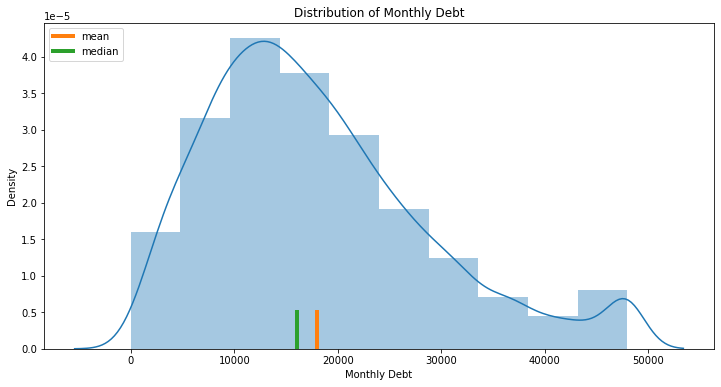

	Mean= 18012.23    Median= 16076.5  


In [133]:
#выбросы заменяем на квантиль 97.5
wired_debt = np.percentile(df.loc[df['Monthly Debt'].notna(),'Monthly Debt'], 97.5)
df['Monthly Debt Outlier'] = 0
df.loc[df['Monthly Debt'] > wired_debt, 'Monthly Debt Outlier'] = 1
df.loc[df['Monthly Debt'] > wired_debt, 'Monthly Debt'] = wired_debt

f_plot_distribution('Monthly Debt')

In [134]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier,Years of Credit History Outlier,Maximum Open Credit Outlier,Current Loan Amount Outlier,Current Credit Balance Outlier,Monthly Debt Outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,1,0,0,0,0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,0,1,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,34.4,1182434.0,0.0,NaN,0.0,...,1,0,0,0,0,1,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,0,1,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,0,0,1,0,0,0,0,0,0,0


In [135]:
#Credit Score                    
#1557 пропусков
df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

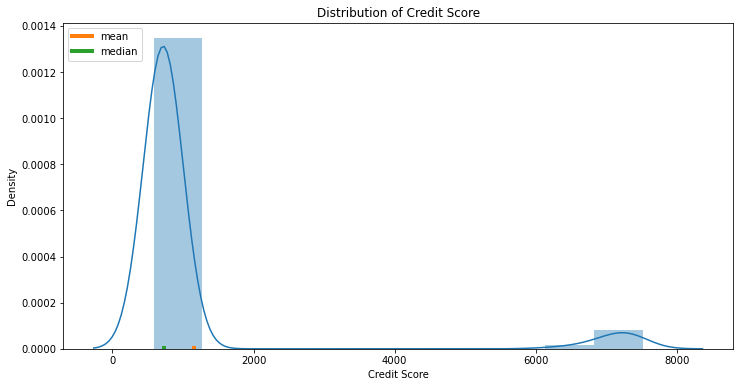

	Mean= 1151.09    Median= 731.0  


In [136]:
f_plot_distribution('Credit Score')
#распределение непонятное, возможно, это не выбросы, так как 1. этот признак не поясняется
# 2. возможно есть небольшое количество людей, у которых кредитный рейтинг большой.
#оставим так

### 3. Обработка пропусков<a class="anchor" id="course_project_review"></a>

Комментарий:

по итогам предыдующей работы выводы:


###### 1. Количество пропусков

Annual Income                   1557

Years in current job             371

Months since last delinquent    4081

Bankruptcies                      14

Credit Score                    1557



###### 2. Как заполнять

Annual Income и Credit Score - пропусков много, поэтому их заполним с помощью модели ML

Years in current job - заменим на минимальное значение >1 года

Months since last delinquent - так как больше половины пропуски, выкинем этот признак

Bankruptcies - заменим на 0




In [137]:
"""Функция производит визуальную оценку распределения признака, а так же строит QQ-график"""
def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)

    plt.show()

In [138]:
#Annual Income - годовой доход 
#1557 пропусков
df['Annual Income'].describe()

count    5.943000e+03
mean     1.326514e+06
std      6.681846e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      3.261279e+06
Name: Annual Income, dtype: float64

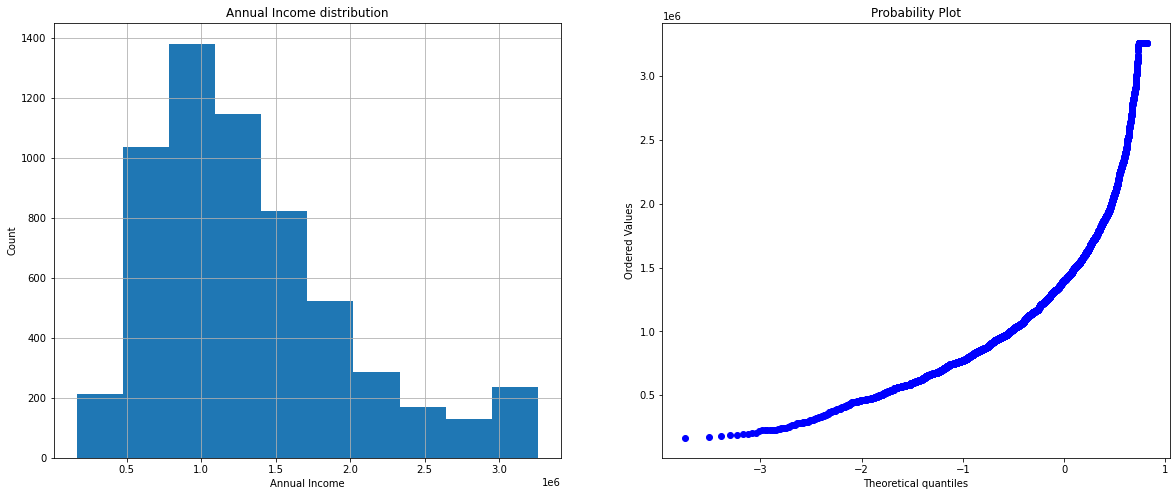

In [139]:
hist_qq('Annual Income')

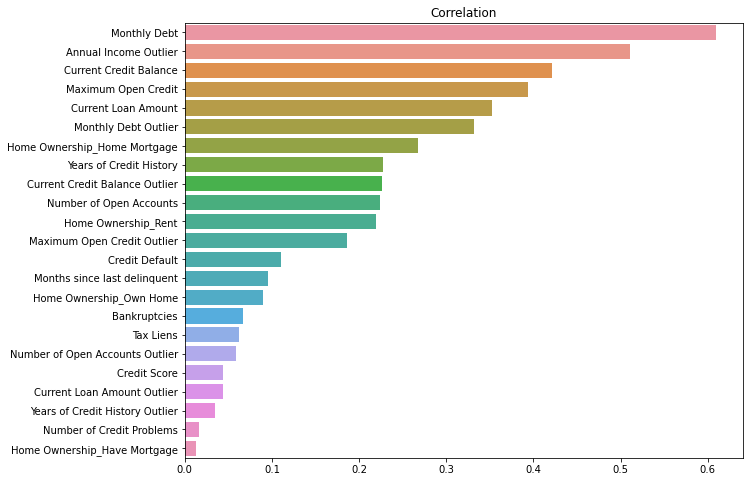

In [140]:
#Заполняем попуски при помощи Random Forest
# Посмотрим как признак коррелирует с другими признаками
FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [141]:
# для обучения выбираем 11 наиболее влияющих признаков
TARGET_FEATURE = ['Monthly Debt','Current Credit Balance', 'Maximum Open Credit','Current Loan Amount',
                  'Home Ownership_Home Mortgage', 'Years of Credit History', 'Number of Open Accounts','Home Ownership_Rent']
#list(corr_Annual_Income.index[0:11])
TARGET_FEATURE

['Monthly Debt',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Home Ownership_Home Mortgage',
 'Years of Credit History',
 'Number of Open Accounts',
 'Home Ownership_Rent']

In [142]:
# отбираем набор данных для обучения
data_Annual_Income = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]
data_Annual_Income

,Monthly Debt,Current Credit Balance,Maximum Open Credit,Current Loan Amount,Home Ownership_Home Mortgage,Years of Credit History,Number of Open Accounts,Home Ownership_Rent,Annual Income
0,7914.00,47386.0,685960.0,785872.56,0,26.3,11.0,0,482087.0
1,18373.00,394972.0,1181730.0,264968.00,0,15.3,15.0,0,1025487.0
2,13651.00,308389.0,1182434.0,785872.56,1,34.4,11.0,0,751412.0
3,11338.00,95855.0,147400.0,121396.00,0,22.5,8.0,0,805068.0
4,7180.00,93309.0,385836.0,125840.00,0,13.6,13.0,1,776264.0
...,...,...,...,...,...,...,...,...,...
7491,47950.15,108889.0,280170.0,437404.00,1,21.3,18.0,0,2833185.0
7493,27562.00,167428.0,821480.0,448052.00,0,16.5,14.0,1,1257610.0
7495,1900.00,73492.0,107866.0,129360.00,0,8.5,3.0,1,402192.0
7496,12783.00,456399.0,686312.0,444048.00,1,26.5,10.0,0,1533984.0


In [143]:
data_Annual_Income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  5943 non-null   float64
 1   Current Credit Balance        5943 non-null   float64
 2   Maximum Open Credit           5943 non-null   float64
 3   Current Loan Amount           5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Years of Credit History       5943 non-null   float64
 6   Number of Open Accounts       5943 non-null   float64
 7   Home Ownership_Rent           5943 non-null   uint8  
 8   Annual Income                 5943 non-null   float64
dtypes: float64(7), uint8(2)
memory usage: 383.0 KB


In [144]:
# учимся на RandomForestRegressor
#%%time

# model_Annual_Income = RandomForestRegressor(n_estimators=400, max_depth=9, random_state=21)
# model_Annual_Income.fit(data_Annual_Income[TARGET_FEATURE], data_Annual_Income['Annual Income'])

In [145]:
# заполняем пропуски на основе обученной модели
y_annual_income = df.loc[(df['Annual Income'].isnull()), ['Annual Income']]

y_annual_income 

,Annual Income
5,NaN
8,NaN
9,NaN
10,NaN
16,NaN
...,...
7482,NaN
7492,NaN
7494,NaN
7498,NaN


In [146]:
#df.loc[(df['Annual Income'].isnull()), ['Annual Income']] = model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

In [147]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.326514e+06
std      6.681846e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      3.261279e+06
Name: Annual Income, dtype: float64

In [148]:
# смотрим, какое распределение получилось

shapiro(df['Annual Income'])

ShapiroResult(statistic=nan, pvalue=1.0)

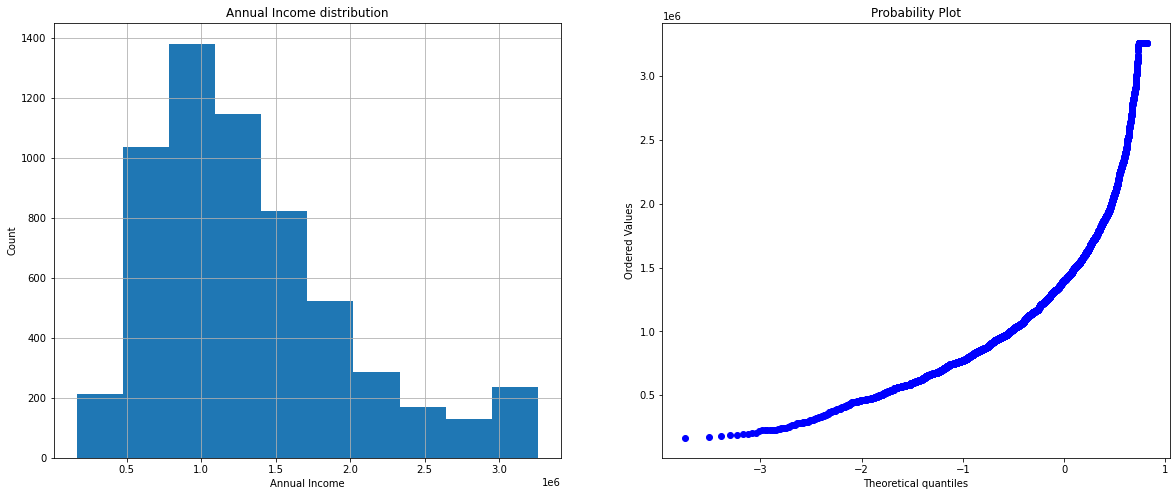

In [149]:
hist_qq('Annual Income')

In [150]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, 'Annual Income']
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, 'Annual Income']

In [151]:
#mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

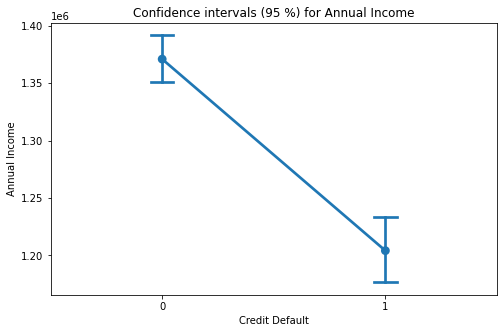

In [152]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

In [153]:
#'Bankruptcies'
# 14 пропусков
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [154]:
df['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [155]:
len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                371
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                         14
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


In [156]:
#заменяем проруски, на самое частое значение - на ноль
df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0

len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                371
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


In [157]:
#Credit Score 
#1557 пропусков
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [158]:
len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                371
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


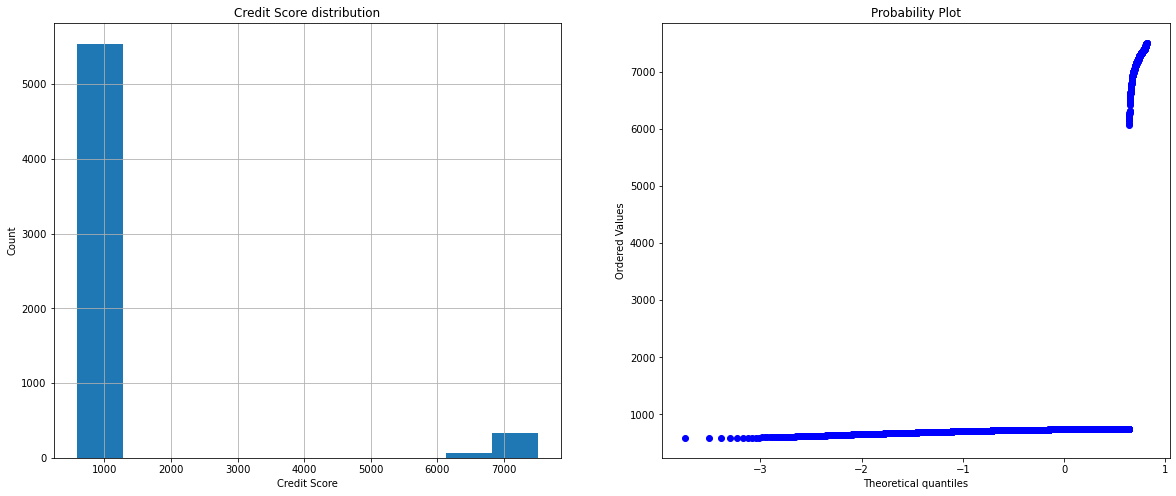

In [159]:
hist_qq('Credit Score')

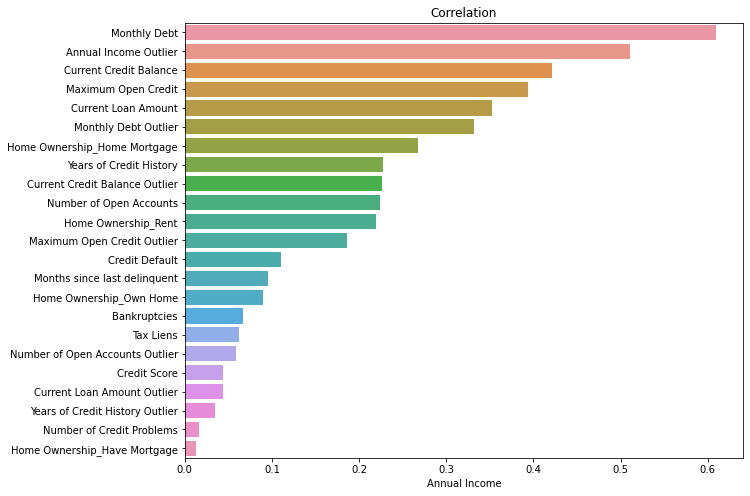

In [160]:
#Заполняем попуски при помощи Random Forest
#Посмотрим как признак коррелирует с другими признаками
FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [161]:
# для обучения выбираем 8 наиболее влияющих признаков
TARGET_FEATURE_Credit_Score = list(corr_Credit_Score.index[0:11])
TARGET_FEATURE_Credit_Score 

['Monthly Debt',
 'Annual Income Outlier',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Monthly Debt Outlier',
 'Home Ownership_Home Mortgage',
 'Years of Credit History',
 'Current Credit Balance Outlier',
 'Number of Open Accounts',
 'Home Ownership_Rent']

In [162]:
# отбираем набор данных для обучения
data_Credit_Score = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE_Credit_Score + ['Credit Score']]
data_Credit_Score

,Monthly Debt,Annual Income Outlier,Current Credit Balance,Maximum Open Credit,Current Loan Amount,Monthly Debt Outlier,Home Ownership_Home Mortgage,Years of Credit History,Current Credit Balance Outlier,Number of Open Accounts,Home Ownership_Rent,Credit Score
0,7914.00,0,47386.0,685960.0,785872.56,0,0,26.3,0,11.0,0,749.0
1,18373.00,0,394972.0,1181730.0,264968.00,0,0,15.3,0,15.0,0,737.0
2,13651.00,0,308389.0,1182434.0,785872.56,0,1,34.4,0,11.0,0,742.0
3,11338.00,0,95855.0,147400.0,121396.00,0,0,22.5,0,8.0,0,694.0
4,7180.00,0,93309.0,385836.0,125840.00,0,0,13.6,0,13.0,1,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7491,47950.15,0,108889.0,280170.0,437404.00,1,1,21.3,0,18.0,0,704.0
7493,27562.00,0,167428.0,821480.0,448052.00,0,0,16.5,0,14.0,1,676.0
7495,1900.00,0,73492.0,107866.0,129360.00,0,0,8.5,0,3.0,1,697.0
7496,12783.00,0,456399.0,686312.0,444048.00,0,1,26.5,0,10.0,0,7410.0


In [163]:
data_Credit_Score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Monthly Debt                    5943 non-null   float64
 1   Annual Income Outlier           5943 non-null   int64  
 2   Current Credit Balance          5943 non-null   float64
 3   Maximum Open Credit             5943 non-null   float64
 4   Current Loan Amount             5943 non-null   float64
 5   Monthly Debt Outlier            5943 non-null   int64  
 6   Home Ownership_Home Mortgage    5943 non-null   uint8  
 7   Years of Credit History         5943 non-null   float64
 8   Current Credit Balance Outlier  5943 non-null   int64  
 9   Number of Open Accounts         5943 non-null   float64
 10  Home Ownership_Rent             5943 non-null   uint8  
 11  Credit Score                    5943 non-null   float64
dtypes: float64(7), int64(3), uint8(2)


In [164]:
# учимся на RandomForestRegressor
#%%time

# model_Credit_Score = RandomForestRegressor(n_estimators=400, max_depth=9, random_state=21)
# model_Credit_Score.fit(data_Credit_Score[TARGET_FEATURE_Credit_Score], data_Credit_Score['Credit Score'])

In [165]:
# df.loc[(df['Credit Score'].isnull()), ['Credit Score']] = model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE_Credit_Score])
                                                                                            

In [166]:
df.loc[(df['Credit Score'].isnull()), ['Credit Score']] 

,Credit Score
5,NaN
8,NaN
9,NaN
10,NaN
16,NaN
...,...
7482,NaN
7492,NaN
7494,NaN
7498,NaN


In [167]:
len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                371
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


In [168]:
shapiro(df['Credit Score'])

ShapiroResult(statistic=nan, pvalue=1.0)

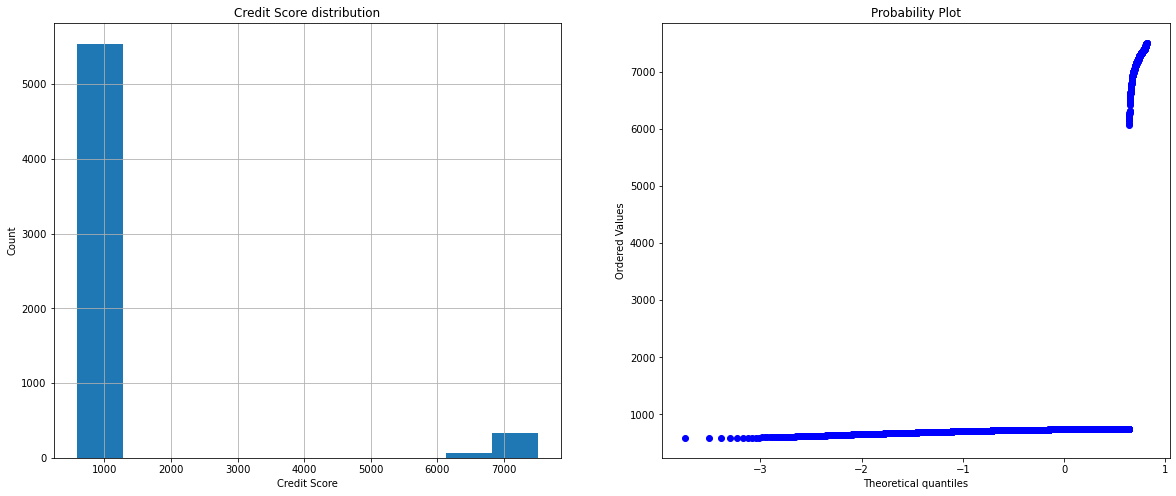

In [169]:
hist_qq('Credit Score')

In [170]:
# Credit_Score_with_target_s = df[['Credit Score', 'Credit Default']]
# Credit_Score_target_0 = df.loc[df['Credit Default'] == 0, 'Credit Score']
# Credit_Score_target_1 = df.loc[df['Credit Default'] == 1, 'Credit Score']

In [171]:
# mannwhitneyu(Credit_Score_target_0, Credit_Score_target_1)

In [172]:
# plt.figure(figsize=(8,5))

# sns.pointplot(x='Credit Default', y='Credit Score', data=Credit_Score_with_target_s, capsize=.1)
# plt.title('Confidence intervals (95 %) for Credit Score')

# plt.show()

In [173]:
#Years in current job 371 пропуск
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [174]:
df['Years in current job'].mode()

0    10+ years
dtype: object

In [175]:
#заменяем проруски, на моду
df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()

len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                370
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


In [176]:
# заменяем на < 1 year
df.loc[df['Years in current job'].isna(), 'Years in current job'] = '< 1 year'


In [177]:
df['Years in current job'].mode()

0    10+ years
dtype: object

In [178]:
df['Years in current job'].value_counts()

10+ years    2333
< 1 year      933
2 years       705
3 years       620
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [179]:
len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                  0
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0


In [180]:
#удаляем Months since last delinquent
df.drop('Months since last delinquent', axis=1, inplace=True)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Annual Income Outlier,Number of Open Accounts Outlier,Years of Credit History Outlier,Maximum Open Credit Outlier,Current Loan Amount Outlier,Current Credit Balance Outlier,Monthly Debt Outlier
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,...,0,1,0,0,0,0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,...,0,1,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,34.4,1182434.0,0.0,0.0,debt consolidation,...,1,0,0,0,0,1,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,...,0,1,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,...,0,0,1,0,0,0,0,0,0,0


In [181]:
len(df) - df.count()

Home Ownership                        0
Annual Income                      1557
Years in current job                  0
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_Have Mortgage          0
Home Ownership_Home Mortgage          0
Home Ownership_Own Home               0
Home Ownership_Rent                   0
Annual Income Outlier                 0
Number of Open Accounts Outlier       0
Years of Credit History Outlier       0
Maximum Open Credit Outlier           0
Current Loan Amount Outlier           0


In [182]:
"""функция для предобработки выбросов и пропусков, изменения и генерации признаков"""
def data_preprocessing(raw_df):
    
    # Make a copy of DataFrame
    df = raw_df.copy()  
    
    # Some constants
    wired_income = np.percentile(df.loc[df['Annual Income'].notna(),'Annual Income'], 97)
    wired_accounts = np.percentile(df.loc[df['Number of Open Accounts'].notna(),'Number of Open Accounts'], 99)
    wired_history = np.percentile(df.loc[df['Years of Credit History'].notna(),'Years of Credit History'], 97)
    wired_credit = np.percentile(df.loc[df['Maximum Open Credit'].notna(),'Maximum Open Credit'], 97.5)
    wired_amount = np.percentile(df.loc[df['Current Loan Amount'].notna(),'Current Loan Amount'], 88)
    wired_balance = np.percentile(df.loc[df['Current Credit Balance'].notna(),'Current Credit Balance'], 97.5)
    wired_debt = np.percentile(df.loc[df['Monthly Debt'].notna(),'Monthly Debt'], 97.5)
        
    # Converts types
    object_cols = df.select_dtypes(include='object').columns.tolist()
    float_cols = df.select_dtypes(include='float64').columns.tolist()

    df[object_cols] = df[object_cols].astype('category')
    df[float_cols] = df[float_cols].astype('float32')
    
    # Working with outliers section
    # Annual Income
    df['Annual Income Outlier'] = 0
    df.loc[df['Annual Income'] > wired_income, 'Annual Income Outlier'] = 1
    df.loc[df['Annual Income'] > wired_income, 'Annual Income'] = wired_income
    
    # Number of Open Accounts
    df['Number of Open Accounts Outlier'] = 0
    df.loc[df['Number of Open Accounts'] > wired_accounts, 'Number of Open Accounts Outlier'] = 1
    df.loc[df['Number of Open Accounts'] > wired_accounts, 'Number of Open Accounts'] = wired_accounts
    
    # Years of Credit History
    df['Years of Credit History Outlier'] = 0
    df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History Outlier'] = 1
    df.loc[df['Years of Credit History'] > wired_history, 'Years of Credit History'] = wired_history
    
    # Maximum Open Credit
    condition = ((df['Maximum Open Credit'] == 0) | (df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.975)))
    df['Maximum Open Credit Outlier'] = 0
    df.loc[condition, 'Maximum Open Credit Outlier'] = 1
    df.loc[condition, 'Maximum Open Credit'] = wired_credit
    
    # Current Loan Amount
    df['Current Loan Amount Outlier'] = 0
    df.loc[df['Current Loan Amount'] > wired_amount, 'Current Loan Amount Outlier'] = 1
    df.loc[df['Current Loan Amount'] > wired_amount, 'Current Loan Amount'] = wired_amount
    
    # Current Credit Balance
    df['Current Credit Balance Outlier'] = 0
    df.loc[df['Current Credit Balance'] > wired_balance, 'Current Credit Balance Outlier'] = 1
    df.loc[df['Current Credit Balance'] > wired_balance, 'Current Credit Balance'] = wired_balance
    
    # Monthly Debt
    df['Monthly Debt Outlier'] = 0
    df.loc[df['Monthly Debt'] > wired_debt, 'Monthly Debt Outlier'] = 1
    df.loc[df['Monthly Debt'] > wired_debt, 'Monthly Debt'] = wired_debt
    
    # Fill NaN section
    # Annual Income
    TARGET_FEATURE_Annual_Income = ['Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit','Current Loan Amount',
                                    'Years of Credit History', 'Number of Open Accounts',]
    data_Annual_Income = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE_Annual_Income + ['Annual Income']]
    model_Annual_Income = RandomForestRegressor(n_estimators=400, max_depth=9, random_state=21)
    model_Annual_Income.fit(data_Annual_Income[TARGET_FEATURE_Annual_Income], data_Annual_Income['Annual Income'])
    df.loc[(df['Annual Income'].isnull()), ['Annual Income']] = model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE_Annual_Income])
    
    # Bankruptcies
    df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
    
    # Credit Score
    TARGET_FEATURE_Credit_Score = ['Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Current Loan Amount', 
                     'Years of Credit History', 'Number of Open Accounts']
    data_Credit_Score = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE_Credit_Score + ['Credit Score']]
    model_Credit_Score = RandomForestRegressor(n_estimators=400, max_depth=9, random_state=21)
    model_Credit_Score.fit(data_Credit_Score[TARGET_FEATURE_Credit_Score], data_Credit_Score['Credit Score'])
    df.loc[(df['Credit Score'].isnull()), ['Credit Score']] = model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE_Credit_Score])
    
    # Years in current job
    df.loc[df['Years in current job'].isna(), 'Years in current job'] = '< 1 year'
    
    # Months since last delinquent
    df = df.drop(columns=['Months since last delinquent'])
    
    if TARGET in df.columns.tolist():
        df.dropna(inplace=True)
        df[TARGET] = df[TARGET].astype('int8')       
        
    #Some changes
    # Term
    df['Term'] = pd.Series(df['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)
    
    # Years in current job
    job_years_dict = {'< 1 year': 0,
                      '1 year': 1,
                      '2 years': 2,
                      '3 years': 3,
                      '4 years': 4,
                      '5 years': 5,
                      '6 years': 6,
                      '7 years': 7,
                      '8 years': 8,
                      '9 years': 9,
                      '10+ years': 10}
    df['Years in current job'] = pd.Series(df['Years in current job'].map(job_years_dict), dtype=np.int8)
    
    # Credit Score Cat
    df['Credit Score Cat'] = 0
    df.loc[(df['Credit Score'] >= 580) & (df['Credit Score'] < 670), 'Credit Score Cat'] = 1
    df.loc[(df['Credit Score'] >= 670) & (df['Credit Score'] < 730), 'Credit Score Cat'] = 2
    df.loc[(df['Credit Score'] >= 730) & (df['Credit Score'] < 735), 'Credit Score Cat'] = 3
    df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 755), 'Credit Score Cat'] = 4
    df.loc[df['Credit Score'] > 755, 'Credit Score Cat'] = -1 
    
    df['No Tax Liens'] = 0
    df.loc[(df['Tax Liens'] == 0), 'No Tax Liens'] = 1
    df['No Credit Problems'] = 0
    df.loc[(df['Number of Credit Problems'] == 0), 'No Credit Problems'] = 1
    df['No Bankruptcies'] = 0
    df.loc[(df['Bankruptcies'] == 0), 'No Bankruptcies'] = 1   
    
    # Makes dummies
    df = pd.get_dummies(df, drop_first=True)
    renew_prop = 'Purpose_renewable energy'
    if renew_prop not in df.columns.tolist():
        df[renew_prop] = 0
    
   
    return df
    

### 4. Анализ данных <a class="anchor" id="course_project_review"></a>

In [183]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [184]:
TARGET = 'Credit Default'


In [ ]:
df = data_preprocessing(df)
df.head()

In [ ]:
df.describe().T

In [ ]:
df.info

In [ ]:
BASE_FEATURE_NAMES = df.columns.drop(TARGET).tolist()
BASE_FEATURE_NAMES

In [ ]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

In [ ]:
test_df.describe().T

In [ ]:
# преобразуем тестовый датасет
test_df = data_preprocessing(test_df)
test_df.head()

In [ ]:
test_df.describe().T

In [ ]:
def heatmap(df):
    corr = df.corr()

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(10, 240, n=200),
        square=True
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

In [ ]:
heatmap(df.select_dtypes(exclude='uint8'))

In [ ]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [ ]:
# Оценка признака "Credit Score" в разрезе целевой переменной
limit_bal_with_target_s = df[['Credit Score', TARGET]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Credit Score']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit ScoreL grouped by target variable')
plt.show()

In [ ]:
df['Credit Score'].value_counts()

In [ ]:
# Оценка признака "Term" в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET, data=df)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
hist_qq('Credit Score')

In [ ]:
hist_qq('Term')

In [ ]:
# График зависимости величины кредита от годового дохода с нанесением целевого класса
plt.figure(figsize=(12,12))
df.plot(kind="scatter", x="Annual Income", y="Current Loan Amount", alpha=0.4,
    c="Credit Default", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(12,12),
    sharex=False)
plt.grid(True)
plt.show()

In [ ]:
# распределение величины кредита
plt.style.use('seaborn-bright')
plt.figure(figsize=(12,12))
sns.distplot(df['Current Loan Amount'])
plt.title('Distribution of Current Loan Amount')
plt.grid(True)

In [ ]:
df['Credit Score Cat'].value_counts()

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### 5. Отбор признаков. Балансировка классов.  <a class="anchor" id="course_project_review"></a>

In [ ]:
BASE_FEATURE_NAMES

In [ ]:
FEATURE_NAMES_SELECTED = ['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Score Cat',
 'No Tax Liens',
 'No Credit Problems',
 'No Bankruptcies',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding'
                         ]

In [ ]:
df.dtypes

In [ ]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                         'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                        'Number of Credit Problems', 'Bankruptcies', 'Term', 'Current Loan Amount', 
                        'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Score Cat', 
                        'No Tax Liens', 'No Credit Problems', 'No Bankruptcies']

# Annual Income                      float32
# Years in current job                  int8
# Tax Liens                          float32
# Number of Open Accounts            float32
# Years of Credit History            float32
# Maximum Open Credit                float32
# Number of Credit Problems          float32
# Bankruptcies                       float32
# Term                                  int8
# Current Loan Amount                float32
# Current Credit Balance             float32
# Monthly Debt                       float32
# Credit Score                       float32
# Credit Default                        int8
# Annual Income Outlier                int64
# Number of Open Accounts Outlier      int64
# Years of Credit History Outlier      int64
# Maximum Open Credit Outlier          int64
# Current Loan Amount Outlier          int64
# Current Credit Balance Outlier       int64
# Monthly Debt Outlier                 int64
# Credit Score Cat                     int64
# No Tax Liens                         int64
# No Credit Problems                   int64
# No Bankruptcies                      int64

In [ ]:
#Нормализация данных - с ней результат хуже получается
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

# df = df_norm.copy()

In [ ]:
#Разбиение на train и test
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

In [ ]:
# делала, результат хуже, убрала
# Балансировка целевой переменной
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
# df_balanced[TARGET].value_counts()

In [ ]:
# X_train = df_balanced.drop(columns=TARGET)
# y_train = df_balanced[TARGET]

### 5. Построение модели.  Борьба с переобучением<a class="anchor" id="course_project_review"></a>

In [ ]:
def get_cat_features(df):
    
    cat_features_list = []
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
       
    for cf in object_cols:
        cat_features_list.append(df.columns.get_loc(cf))
    
    return cat_features_list

In [ ]:
"""Функция для определения важности параметров"""
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [ ]:
frozen_params = {'silent': True,
                 'random_state': 21,
                 'n_estimators': 1200,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'class_weights': [1, 2.2],
                 'early_stopping_rounds': 800
                }

In [ ]:
# CatBoostClassifier
cat_model = catb.CatBoostClassifier(**frozen_params)

cat_model.fit(X_train, y_train)

In [ ]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
#оценка важности признаков
important_features_top = show_feature_importances(X.columns, cat_model.feature_importances_, get_top=15)

In [ ]:
#сохраение финальной модели
with open('./course_project_model.pkl', 'wb') as file:
    pickle.dump(cat_model, file)

In [ ]:
#делаем предсказание на тестовой выборке
test_predictions_1 = cat_model.predict(test_df[FEATURE_NAMES_SELECTED])


In [ ]:
test_predictions_1

In [ ]:
test_df['Credit Default'] = test_predictions_1
test_df['Credit Default'] 

In [ ]:
test_df['Credit Default'].describe()

In [ ]:
result = test_df['Credit Default']
result

In [ ]:
result.to_csv('s_tsimbalistaia_predictions.csv', index=False)
result.head()

### 6. Оценка качества. Интерпретация результатов<a class="anchor" id="course_project_review"></a>

In [ ]:
cat_features = get_cat_features(X)
pool1 = Pool(data=X_train, label=y_train, cat_features=cat_features)
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(cat_model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)

In [ ]:
shap_values = cat_model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_train.iloc[1,:])

In [ ]:
shap.summary_plot(shap_values, X_train)

### 7. Выводы<a class="anchor" id="course_project_review"></a>

В целом, найдена сбалансированная модель показывающая примерно равные метрики Precision, Recall и F1. 

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4046
           1       0.72      0.75      0.73      1579

    accuracy                           0.85      5625
   macro avg       0.81      0.82      0.81      5625
weighted avg       0.85      0.85      0.85      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1341
           1       0.55      0.53      0.54       534

    accuracy                           0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.74      0.74      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1105  236
1                251  283

Борьба с переобучением за счет регуляризации приводит к худшим результатам и, на мой взгляд, не требуется. 

Балансировка классов также не ребуется за счет возможности установки весов в классификаторе.